# Simulation of a prism applied to a Non-linear inverse problem using Steepest Descent

## Importing libraries

In [1]:
%matplotlib inline
from fatiando.gridder import regular, spacing
from fatiando.mesher import Prism
from fatiando.utils import ang2vec
from fatiando.gravmag import prism
from fatiando.constants import CM, T2NT
import numpy as np
import matplotlib.pyplot as plt
from visual import histeq

/home/andre/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Prism parameters

### Dimension of the prism

In [2]:
dimx = 5.  # in mm
dimy = 5.
dimz = 5.

In [3]:
Lx = 1e-3*dimx

In [4]:
Ly = 1e-3*dimy

In [5]:
Lz = 1e-3*dimz

### Sensor-to-sample distance

In [6]:
voo = 500.
dist = voo*1e-6
sts = dist + (0.5*Lz) 

## Parameters for the observation coordinate

In [7]:
Nx = 50
Ny = 50
shape = (Nx,Ny)

In [8]:
xmax = 1e-3*6.
xmin = -xmax
ymax = 1e-3*6.
ymin = -ymax

area = [xmin,xmax,ymin,ymax]

In [9]:
x,y,z = regular(area,shape, -sts)

## Generating the sample

In [10]:
intensity = 0.1
inclination = 90.
declination = 0.

In [11]:
mag = ang2vec(intensity,inclination,declination)

In [12]:
sample = [Prism(-0.5*Lx,0.5*Lx,-0.5*Ly,0.5*Ly,-0.5*Lz,0.5*Lz, props={'magnetization': mag})]

## Calculating the observed data

In [13]:
Bz = prism.bz(x,y,z,sample)

In [14]:
np.random.seed(seed=40)

std_noise = 0.02*np.max(np.abs(Bz))

r = np.random.normal(0.0, std_noise, Nx*Ny)

print '%.3f nT' % std_noise

0.896 nT


In [15]:
Bz_obs = Bz + r

## Calculating the predicted data

In [16]:
def pred_data(x,y,h,sample,intensity,inc,dec):
    '''
    Calculate the predicted data.
    '''
    voo = h
    dist = voo*1e-6
    sts = dist + (0.5*Lz) 
    z = -sts*np.ones_like(x)
    
    m = intensity
    jx = np.cos(np.deg2rad(inc))*np.cos(np.deg2rad(dec))
    jy = np.cos(np.deg2rad(inc))*np.sin(np.deg2rad(dec))
    jz = np.sin(np.deg2rad(inc))
    bz = prism.kernelxz(x,y,z,sample[0])*jx+\
         prism.kernelyz(x,y,z,sample[0])*jy+\
         prism.kernelzz(x,y,z,sample[0])*jz
    bz *= CM*T2NT*m
    return  bz

In [22]:
Bz_pred = pred_data(x,y,500.,sample,intensity,inclination,declination)

## Comparison between observed data and predicted data

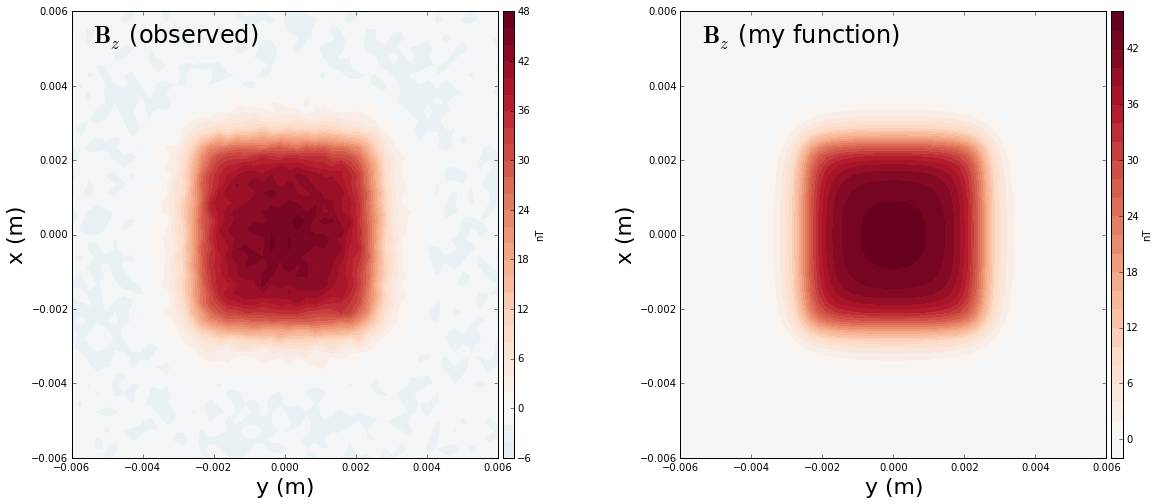

In [23]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (observed)', xy = (0.05, 0.93), 
             xycoords = 'axes fraction', fontsize=24)

plt.subplot(1,2,2)
ranges = saturation_factor*np.abs([Bz_pred.max(), Bz_pred.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_pred.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (my function)', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=24)

plt.show()


## Visualization of the data misfit

In [24]:
Nm = 20
m_range = np.linspace(0.001,1.,num=Nm)

In [25]:
Nh = 20
h_range = np.linspace(10.,1000.,num=Nh)

In [26]:
m_range,h_range = np.meshgrid(m_range,h_range)

In [27]:
shape_phi = (Nm,Nh)

In [28]:
misfit = []
for mi,hi in zip (m_range.ravel(),h_range.ravel()):
    Bz_pred_it = pred_data(x,y,hi,sample,mi,inclination,declination)
    res = Bz_obs - Bz_pred_it 
    misfit.append(np.linalg.norm(res))

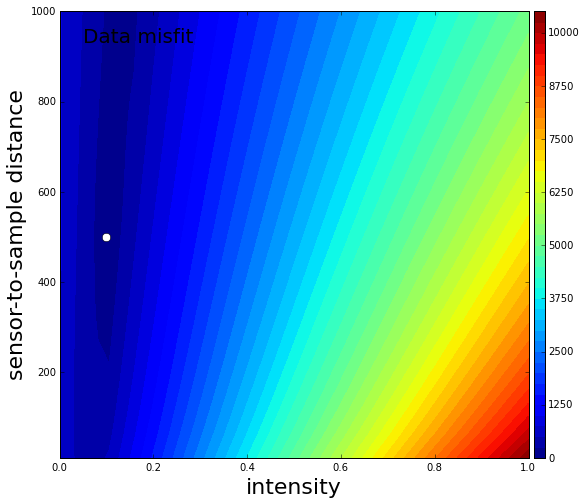

In [29]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(m_range, h_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(intensity,voo,'wo',markersize=8)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('intensity', fontsize = title_font)
plt.ylabel('sensor-to-sample distance', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Calculating the Sensitivity matrix 

In [30]:
def sensitivity(x,y,h,sample,intensity,inc,dec):
    '''
    Calculating the sensitivity matrix numerically.
    '''
    h1 = .01*h
    h2 = .01*intensity
    N = len(x)
    
    A = np.empty([N,2])
    A[:,0] = (pred_data(x,y,h+h1,sample,intensity,inc,dec) - pred_data(x,y,h-h1,sample,intensity,inc,dec))/(2.*h1)
    A[:,1] = (pred_data(x,y,h,sample,intensity+h2,inc,dec) - pred_data(x,y,h,sample,intensity-h2,inc,dec))/(2.*h2)
    return A

## Performing the Steepest Descent method 

In [45]:
alpha = 1e-4
beta =  0.4
itmax = 100
eps = 1e-3

d_sts = []
mag_int = []

d_sts0 = 900.
mag_int0 = 0.9

d_sts.append(d_sts0)
mag_int.append(mag_int0)

phi = []
it  = []
for i in range(itmax):
    m = 0
    lamb = .4
    
    res = Bz_obs - pred_data(x,y,d_sts[i],sample,mag_int[i],inclination,declination)
    G = sensitivity(x,y,d_sts[i],sample,mag_int[i],inclination,declination)
    grad =  np.dot(G.T,res)
    mod = np.linalg.norm(grad)
    
    d_sts.append(d_sts[i] + lamb*grad[0])
    mag_int.append(mag_int[i]  lamb*grad[1])
    
    phi_i = np.linalg.norm(Bz_obs - pred_data(x,y,d_sts[i],sample,mag_int[i],inclination,declination))
    
    phi_plus = np.linalg.norm(Bz_obs - pred_data(x,y,d_sts[i+1],sample,mag_int[i+1],inclination,declination))
    
    phi.append(np.linalg.norm(res))
    it.append(i)
    
    print 'iteration:', i
    print 'p1 = %.2f | p2 = %.2f' % (d_sts[i],mag_int[i])
    print 'phi:', phi_i
    
    while ((phi_plus - phi_i) > (alpha*lamb*mod)):
        m += 1
        lamb = beta**m
        
        d_sts[i+1] = d_sts[i] - lamb*grad[0]
        mag_int[i+1] = mag_int[i] - lamb*grad[1]
        
        phi_plus = np.linalg.norm(Bz_obs - pred_data(x,y,d_sts[i+1],sample,mag_int[i+1],inclination,declination))
        
    if np.abs((phi_plus-phi_i)/phi_i) <= eps:
        break

iteration: 0
p1 = 900.00 | p2 = 0.90
phi: 4792.09093018
iteration: 1
p1 = 900.00 | p2 = 0.09
phi: 261.202654628
iteration: 2
p1 = 900.00 | p2 = 0.13
phi: 105.970594108
iteration: 3
p1 = 900.00 | p2 = 0.12
phi: 105.299007035


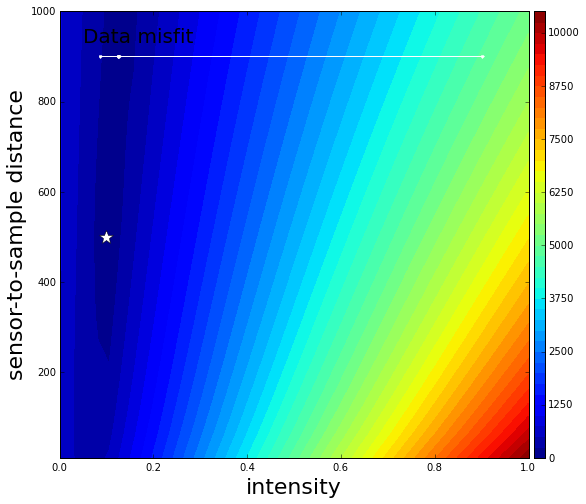

In [46]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(m_range, h_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(intensity,voo,'w*',markersize=15)
plt.plot(mag_int,d_sts,'w.-')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('intensity', fontsize = title_font)
plt.ylabel('sensor-to-sample distance', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Plotting misfit

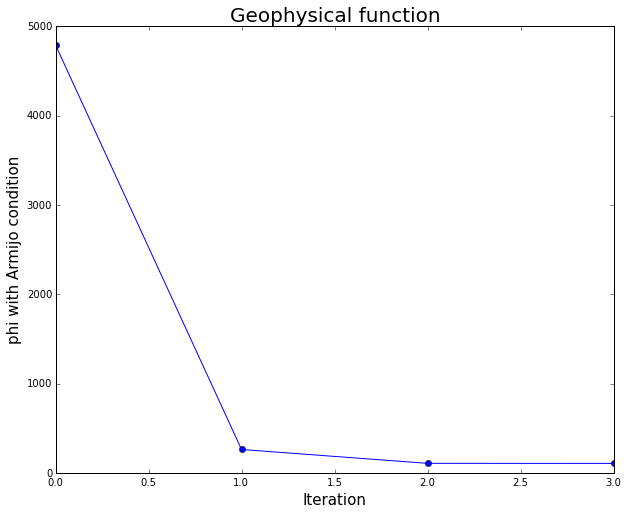

In [47]:
plt.figure(figsize=(10,8))

plt.plot(it, phi, 'o-')
plt.title('Geophysical function',fontsize=20)
plt.ylabel('phi with Armijo condition',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

plt.show()
